In [1]:
import argparse
import importlib
import os
import torch
import yaml
from dataloaders import kitti_loader
from easydict import EasyDict
from torch.utils.data.dataloader import DataLoader
from network._2dpaenet import get_model as DepthCompletionModel

parser = argparse.ArgumentParser(description="Sparse to Dense")
parser.add_argument('-c', '--configs', default="./config/2DPAPENet-kitti.yaml")
configs = parser.parse_args(args=[])
with open(configs.configs, 'r') as config:
    args = yaml.safe_load(config)
args.update(vars(configs))
args = EasyDict(args)
args.result = os.path.join('..', 'results')
args.use_rgb = ('rgb' in args.input)
args.use_d = 'd' in args.input
args.use_g = 'g' in args.input
print(args)

val_dataset = kitti_loader.KittiDepth('test_completion', args)
val_dataset_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

cur_data = next(iter(val_dataset_loader))

model = DepthCompletionModel(args).cuda()
model = model.load_from_checkpoint('./best_2dpaenet.ckpt', args=args, strict=False).cuda()
with torch.no_grad():
    output_data = model(cur_data)

{'format_version': 1, 'network_model': '_2dpaenet', 'criterion': 'l2', 'cpu': False, 'convolutional_layer_encoding': 'xyz', 'dilation_rate': 2, 'mode': 'train', 'baseline_only': False, 'distillation': 'e-e', 'data_folder': '/root/autodl-tmp/DepthKITTI/kitti_depth/depth', 'data_folder_rgb': '/root/autodl-tmp/DepthKITTI/kitti_raw', 'data_folder_save': './submit_test/', 'log_directory': './mylog', 'checkpoint': 'bestmodel', 'input': 'rgbd', 'jitter': 0.1, 'freeze_backbone': False, 'batch_size': 2, 'seed': 0, 'workers': 4, 'epochs': 100, 'start_epoch': 0, 'start_epoch_bias': 0, 'learning_rate': 0.001, 'weight_decay': 1e-06, 'not_random_crop': False, 'random_crop_height': 320, 'random_crop_width': 1216, 'val_h': 352, 'val_w': 1216, 'lr_scheduler': 'StepLR', 'decay_step': 2, 'decay_rate': 0.9, 'gpu': '0', 'monitor': 'val/rmse', 'stop_patience': 5, 'SWA': False, 'swa_lr': 0.001, 'swa_epoch_start': 10, 'train_stage0': 1, 'train_stage1': 3, 'val': 'select', 'rank_metric': 'rmse', 'evaluate': ''

/root/miniconda3/envs/penet/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (AverageMeter). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


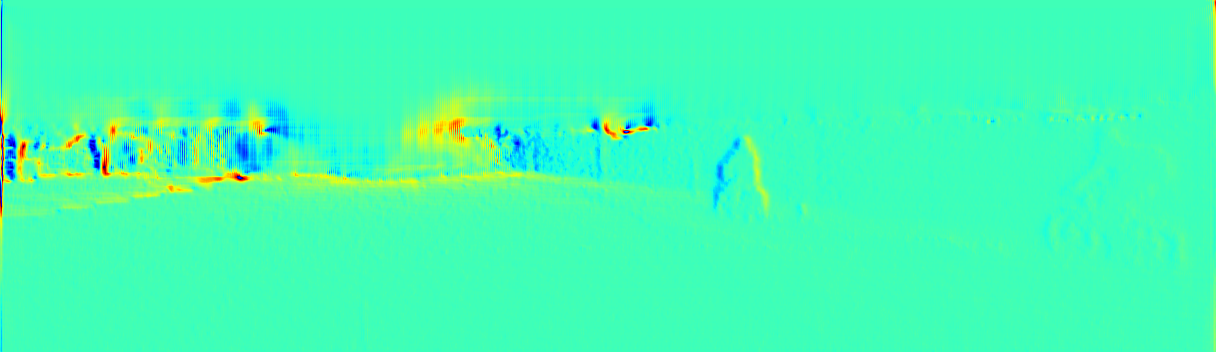

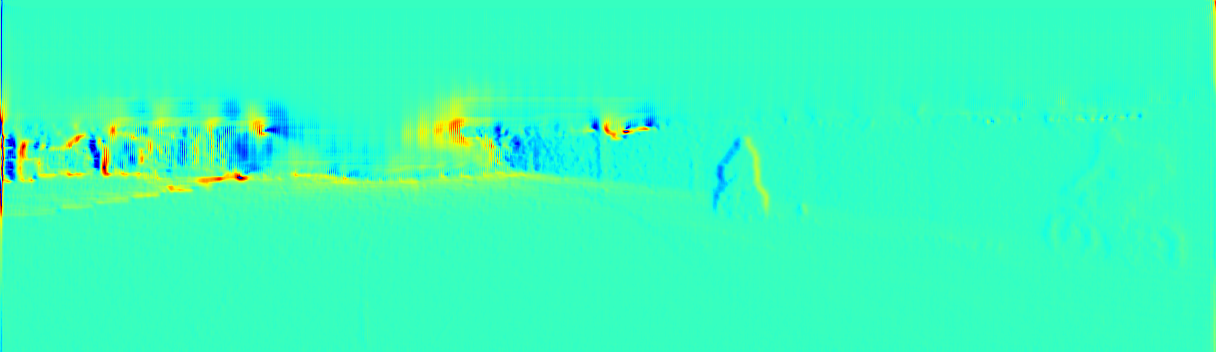

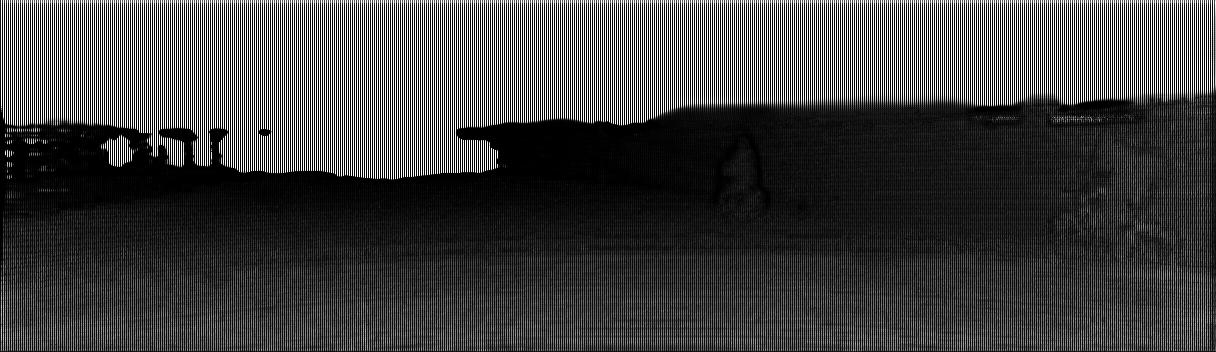

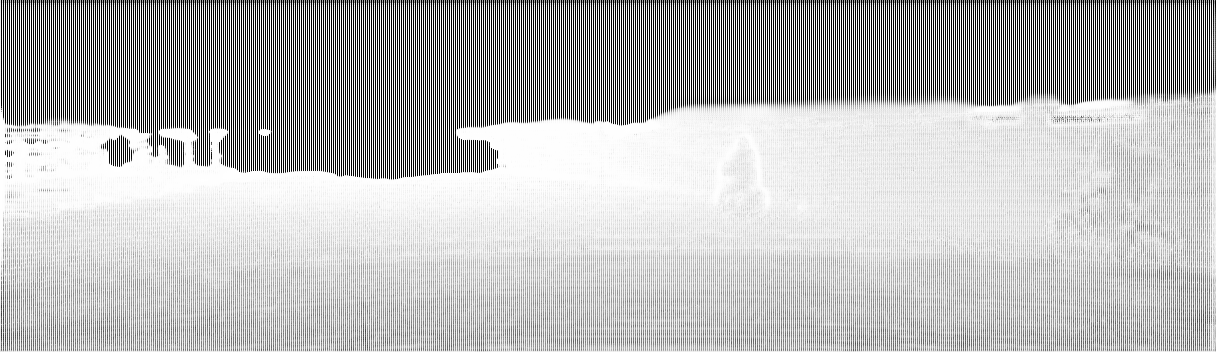

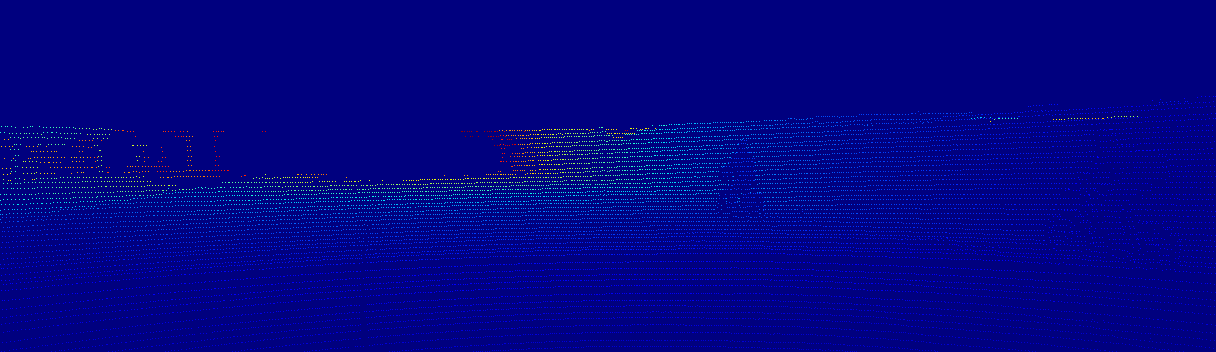

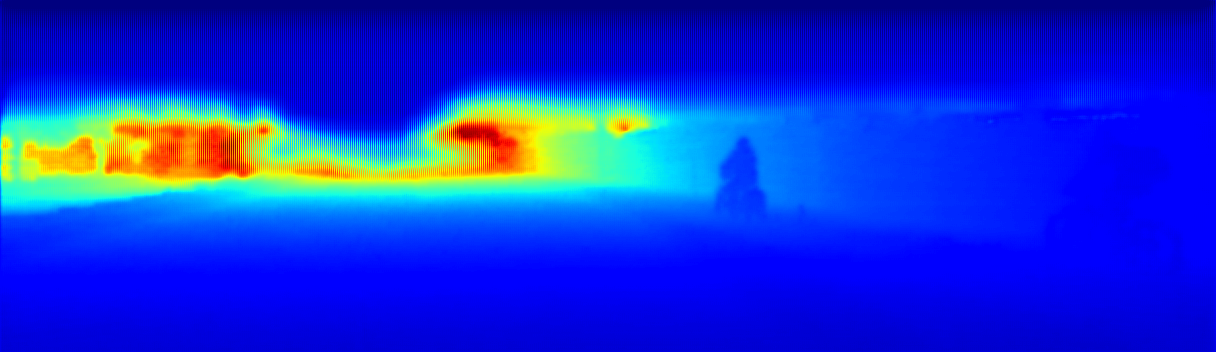

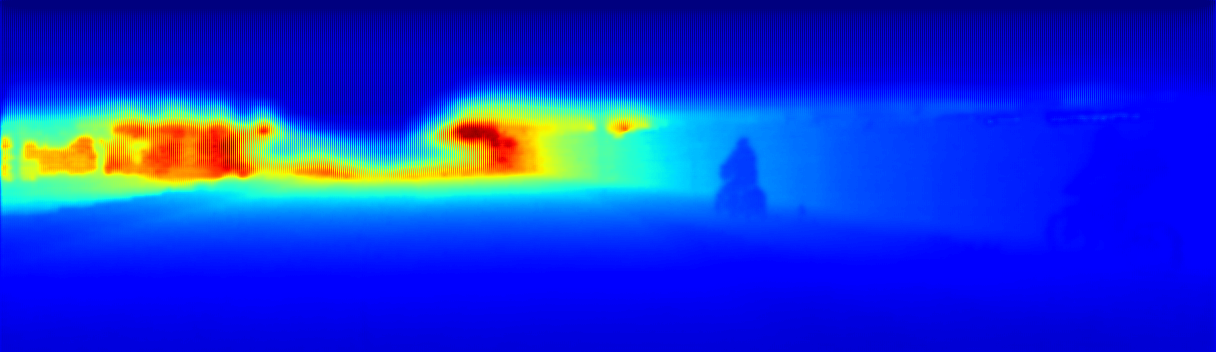

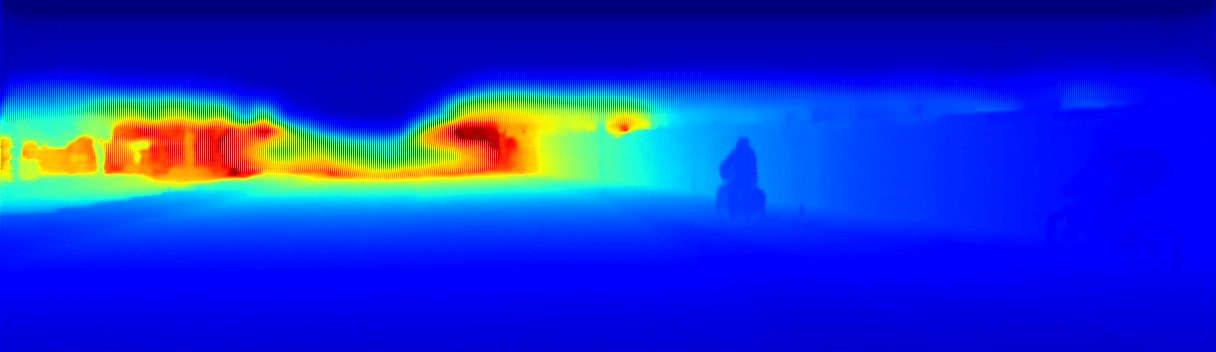

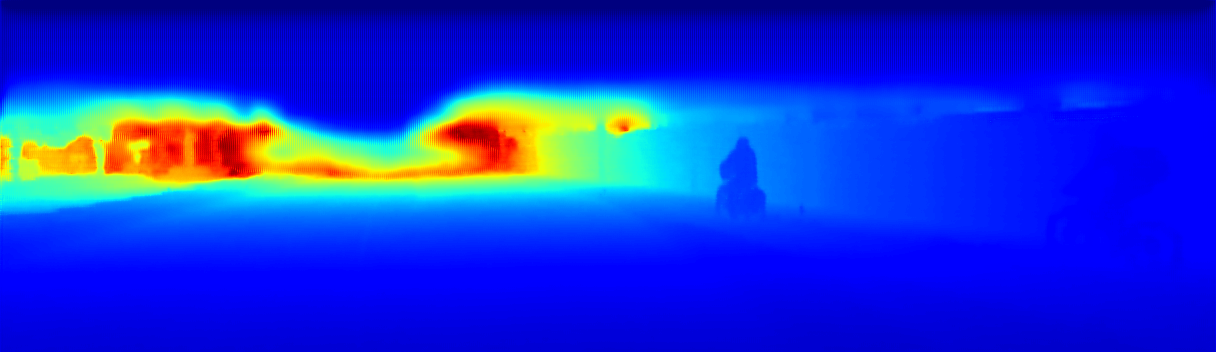

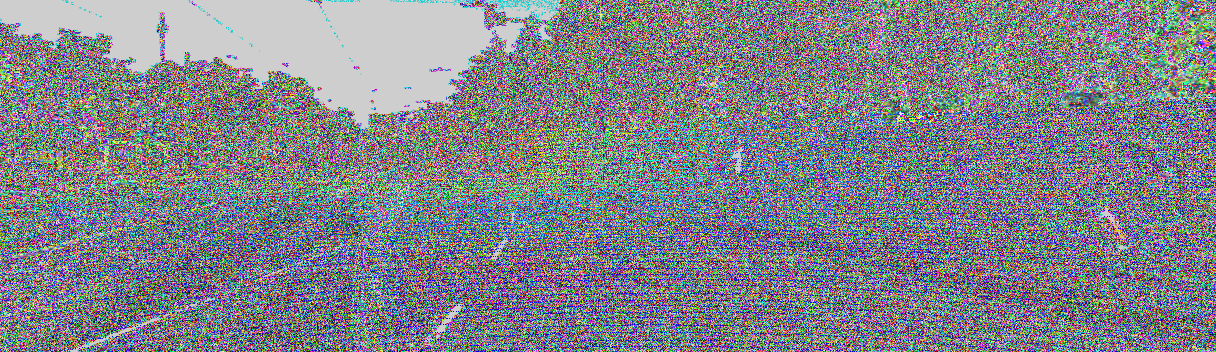

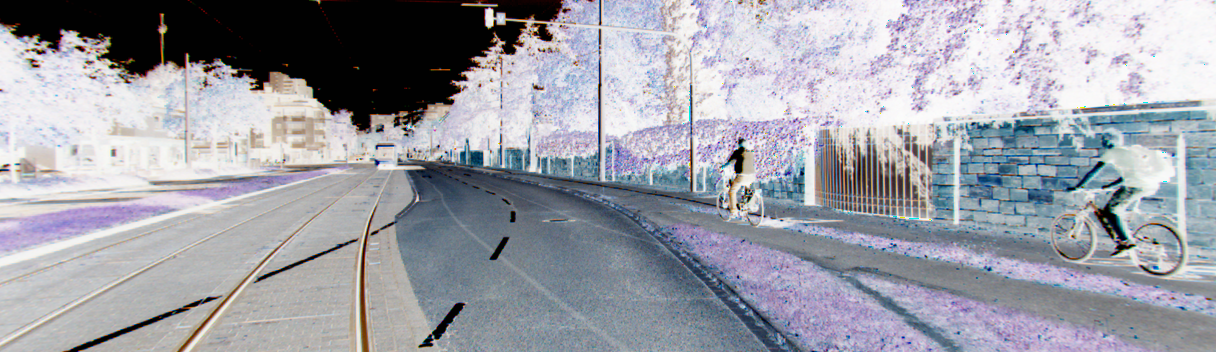

In [16]:
import numpy as np
from PIL import Image
from matplotlib import cm
from torchvision.transforms import transforms

cmap = cm.get_cmap('jet')
sm = cm.ScalarMappable(cmap=cmap)
color_range = sm.to_rgba(np.linspace(0,1,256), bytes=True)[:, 0:3]

show_output = ['mid_edge','cd_edge']

for item in show_output:
    show_output = output_data[item].data.cpu().numpy()
    show_output = np.squeeze(show_output/show_output.max()*255.).astype(np.uint8)
    # show_output = color_range[show_output].astype(np.uint8)
    show_output = Image.fromarray(show_output)
    show_output.show()

show_output = ['mid_branch_confidence','dd_branch_confidence']

for item in show_output:
    show_output = output_data[item].data.cpu().numpy()
    show_output = np.squeeze(show_output/show_output.max()*255.).astype(np.uint8)
    # show_output = color_range[show_output].astype(np.uint8)
    show_output = Image.fromarray(show_output)
    show_output.show()

show_output = ['d','mid_branch_output','cd_branch_output','dd_branch_output','fuse_output']

for item in show_output:
    show_output = output_data[item].data.cpu().numpy()
    show_output = np.squeeze(show_output/show_output.max()*255.).astype(np.uint8)
    show_output = color_range[show_output].astype(np.uint8)
    show_output = Image.fromarray(show_output)
    show_output.show()

d_input = output_data['d'].data.cpu().numpy()
d_input = np.squeeze(d_input/d_input.max()*255.).astype(np.uint8)
mask = output_data['d'].data.cpu().numpy().squeeze()
d_input = color_range[d_input].astype(np.uint8)
rgb_input = output_data['rgb'].squeeze().data.cpu().numpy().transpose(1,2,0)*50.
rgb_input[mask>0] =d_input[mask>0]
rgb_input = Image.fromarray(rgb_input.astype(np.uint8))
rgb_input.show()
rgb_input = output_data['rgb'].squeeze().data.cpu().numpy().transpose(1,2,0)*255.
rgb_input = Image.fromarray(rgb_input.astype(np.uint8))
rgb_input.show()